## This notebook implements target tracking on the fable robot using a deep neural network. For this script, it is important the robot is facing the other way (on/off switch is facing the left such that the negative direction of the x motor is towards your computer). Training data collection takes some time therefore one has been provided for 1 degree increments. Training the model to obtain the weights can take a long time if you make the model too big; I suggest you keep it under 100 hidden units (again a file of the learned weights is provided). 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch

import SNN
import SNN_Trainer as SNN_T

C:\Python38\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
SNN.Net().parameters

<bound method Module.parameters of Net(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (lif2): Leaky()
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)>

In [3]:
model = SNN.Net().fc1.weight + 10

0.44675995558692416


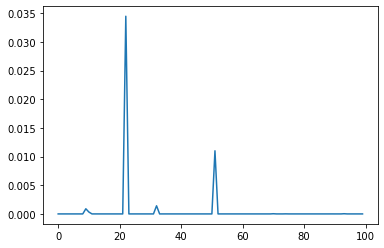

In [4]:
A_plus = 0.040  ## 40 mV
A_minus = -0.04
tau_plus = 0.01  ## 10 ms for NeoCortex basket cells
tau_minus = 0.01
W = np.zeros(100)
x = np.abs(np.random.rand(100))
print(x[2])
for i in range(0,len(W)):
    
    if x[i]>0:
        W[i] = A_plus*np.exp(-x[i]/tau_plus)

    else:
        W[i] = A_minus*np.exp(x[i]/tau_minus)

plt.plot(W)

## Example of Training Trajectory

In [5]:
import os,sys
print("Current working directory: {0}".format(os.getcwd()))

# Change the current working directory
os.chdir(r"C:\Users\Pouya\Documents\SNN Controller\Soft-Robot-Repository\SRobotGym\srobot\envs")
# os.chdir(r"/content/Soft-Robot-Repository")

# Print the current working directory
# sys.path.append(r"C:\Users\Pouya\Documents\SNN Controller\SRobotGym\srobot\envs")
sys.path.append(r"/content/Soft-Robot-Repository/SRobotGym/srobot/envs")
sys.path.append(r"/content/Soft-Robot-Repository/SRobotGym/srobot")
print("Current working directory: {0}".format(os.getcwd()))
import TargetPathTrack as TT

Current working directory: C:\Users\Pouya\Documents\SNN Controller\Soft-Robot-Repository\Simulink Code
Current working directory: C:\Users\Pouya\Documents\SNN Controller\Soft-Robot-Repository\SRobotGym\srobot\envs


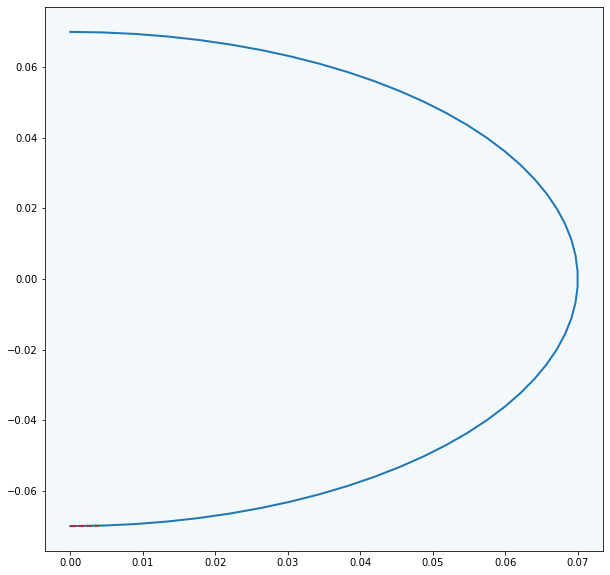

In [6]:
T = TT.racetrack(50,1,0)
Track, P = T.genCircle(1)

In [8]:
 def EXstep(self, agent, runs, env, seeds):
        
        agent.eval()
        rs = []
        Goal_Counter = 0
        Total_Steps = 0
        Action_Counter = np.zeros(runs)

        for run in range(runs):

            observation = env.reset(seeds[run])
            
            Action_Counter[run] = Total_Steps
            
            r = 0
            Total_Steps = 0
            

            for _ in range(self.max_step):
                inp = torch.tensor(observation[:,0:3]).type('torch.FloatTensor').cuda()

                if torch.cuda.device_count() > 1:
                    print("Let's use", torch.cuda.device_count(), "GPUs!")
       
                agent.to(device)
                
                mu = agent(inp)
                mu = mu.cpu().detach().numpy()
                action = mu.reshape(1,3)
                
                if action.any() > 1.42: # Set the pressure limit to the plant
                    
                    act_idx = [n for n,i in enumerate(action) if i>1.42]
                    action[act_idx] =1.42
                    
                    r += 10

                new_observation, reward, done, info = env.step(action)        

                if(done):
                    break
                
                r = r + reward
                Total_Steps += 1 

                old_parameters = np.array(np.reshape(observation, (1, 36)))

                old_DIST = old_parameters[:,-6]
           
                #############################
                observation = new_observation
                #############################
                
                parameters = np.array(np.reshape(observation, (1, 36)))
                
                new_DIST = parameters[:,-6]

            if reward == 0:
                  Goal_Counter += 1        

            ## Penalties for Goal status: 
            
            if reward == -99:
                r += np.sqrt((env.goal[0] - env.sim.arm[0])**2 + (env.goal[1] - env.sim.arm[1])**2) * 10 * 3

            if not done:
                r += np.sqrt((env.goal[0] - env.sim.arm[0])**2 + (env.goal[1] - env.sim.arm[1])**2) * 10 * 3

            rs.append(r)
        GOALS_TOTAL.append(np.copy(Goal_Counter))
        return sum(rs) / runs #, G_Goals

In [ ]:
import numpy as np
import shapely.geometry as sg
from shapely.geometry import Point
import matplotlib.pyplot as plt
import math
import random
from descartes import PolygonPatch

sg.LineString(P).intersection(Track)

In [10]:
# Randomization of starting point
import random
import numpy as np
import matplotlib.pyplot as plt
import math

AAA = random.randrange(50)
print(AAA)
angle = np.linspace(AAA,2*math.pi+AAA,50)
# plt.plot(np.cos(angle),np.sin(angle))
# plt.plot(np.cos(angle[0]),np.sin(angle[0]), 'rX')

6


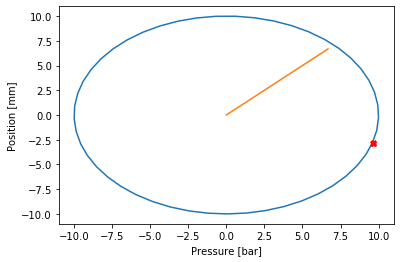

In [11]:
T = 50
x = torch.zeros(T)
y = torch.zeros(T)
P = torch.zeros(3,T)
for i in range(T-1):
    
    P[:,i] = i/T

#     P = torch.rand(3)
    x[i+1] = x[i] + 1/(P[0,i]**2 + 5*P[0,i] + 5)
#     x[i] = 2/(P[0]**2 + 5*P[0] + 5)

    y[i+1] = y[i] + 1/(P[1,i]**2 + 5*P[1,i] + 5)

#     z = 2/(P[2]**2 + 5*P[2] + 5)

#     theta = math.atan(x/y)



# plt.plot(P[1],1/y)
plt.plot(10*np.cos(angle),10*np.sin(angle))
plt.plot(10*np.cos(angle[0]),10*np.sin(angle[0]), 'rX')

plt.plot(x,y)
plt.xlabel("Pressure [bar]")
plt.ylabel("Position [mm]")
plt.show()

In [12]:
AAA = 2*torch.rand(3)
AAA.greater(10)

act_idx = [n for n,i in enumerate(AAA) if i>1.42]
print(act_idx)
AAA[act_idx] =1.42
print(AAA)

[0, 1, 2]
tensor([1.4200, 1.4200, 1.4200])


## Training data Collection

In [13]:
from torchsummary import summary
lr = 0.001
num_steps = 100
num_hidden = 32

model = SNN.Net(num_inputs=3, num_hidden=num_hidden, num_outputs=3)
optimizer = torch.optim.Adam(model.parameters(), lr)
loss_func = torch.nn.MSELoss()
# summary(model, (1, 1,1,3))
print(model)

Net(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (lif2): Leaky()
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)


In [14]:
import os,sys
print("Current working directory: {0}".format(os.getcwd()))

# Change the current working directory
os.chdir(r"C:\Users\Pouya\Documents\SNN Controller\Soft-Robot-Repository\Data")
# os.chdir(r"/content/Soft-Robot-Repository")

# Print the current working directory
# sys.path.append(r"C:\Users\Pouya\Documents\SNN Controller\SRobotGym\srobot\envs")
sys.path.append(r"/content/Soft-Robot-Repository/Data")

Current working directory: C:\Users\Pouya\Documents\SNN Controller\Soft-Robot-Repository\SRobotGym\srobot\envs


## Training

In [15]:
n_Train_epochs = 100
XY_Train_data='SNNTrainingData.csv'
XY_Target_data='SNNTargetData.csv'
SNN_Trainer = SNN_T.Training(XY_Train_data, XY_Target_data) ##, Y_Train_data='Train_y.csv', Y_Target_data ='Target_y.csv') 
NN_Training_E = SNN_Trainer.Train(model, loss_func, optimizer, n_Train_epochs,num_steps)

RuntimeError: The expanded size of the tensor (1) must match the existing size (20) at non-singleton dimension 0.  Target sizes: [1, 32].  Tensor sizes: [20, 32]

In [ ]:
plt.plot(np.arange(n_Train_epochs),NN_Training_E)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Training Error')
# plt.savefig('Error_Y_variation_4000_0.01.jpg')
plt.show()


In [16]:
torch.save(model.state_dict(), 'SNN_Weights.pth')

In [17]:
ExTarget = torch.FloatTensor([[10,10,5],[10,10,5],[10,10,5]])
Error = loss_func(model(ExTarget),ExTarget)
optimizer.zero_grad()
Error.backward(retain_graph=True)
optimizer.step()

RuntimeError: The expanded size of the tensor (1) must match the existing size (3) at non-singleton dimension 0.  Target sizes: [1, 32].  Tensor sizes: [3, 32]

In [18]:
# dir(model.lif1)
# model.lif1.load_state_dict(torch.load('SNN_Weights.pth')['lif1'])
States = list(model.load_state_dict(torch.load('SNN_Weights.pth')))
print(States)

[[], []]


Text(0, 0.5, 'Spikes')

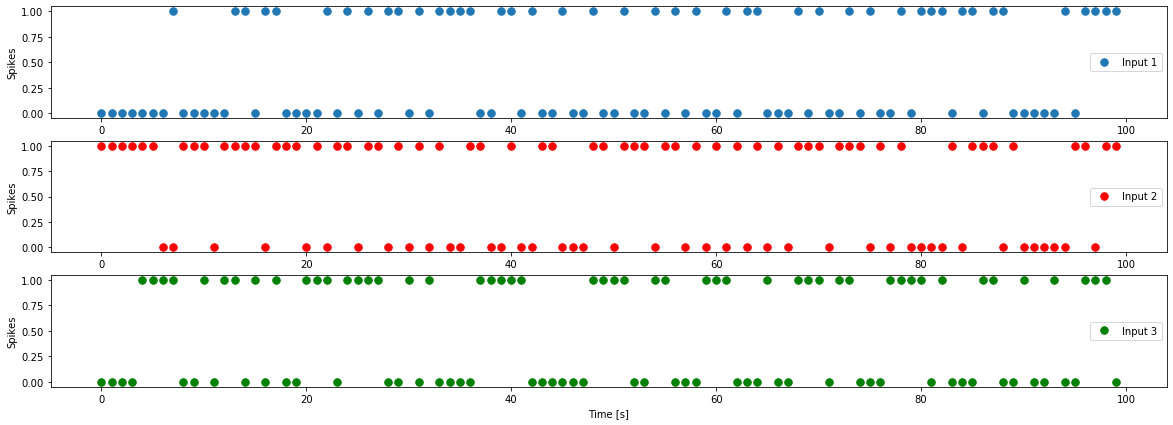

In [19]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Initialize hidden states
mem1 = model.lif1.init_leaky()
mem2 = model.lif2.init_leaky()

# record outputs
mem1_rec = []
mem2_rec = []
spk1_rec = []
spk2_rec = []
spk_in = spikegen.rate_conv(torch.rand((100, 3))).unsqueeze(1)
# >>> print(f"Dimensions of spk_in: {spk_in.size()}")
# "Dimensions of spk_in: torch.Size([200, 1, 784])"
# network simulation
for step in range(num_steps):
    cur1 = model.fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = model.lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = model.fc2(spk1)
    spk2, mem2 = model.lif2(cur2, mem2)

    mem1_rec.append(mem1)
    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem1_rec = torch.stack(mem1_rec)
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plt.figure(figsize=(20,7))
plt.subplot(3,1,1)
plt.plot(spk_in[:,0][:,0],'.', markersize = 15,label='Input 1')
plt.legend(loc='center right')
plt.xlabel('Time [s]')
plt.ylabel('Spikes')

plt.subplot(3,1,2)
plt.plot(spk_in[:,0][:,1],'r.', markersize = 15,label='Input 2')
plt.legend(loc='center right')
plt.xlabel('Time [s]')
plt.ylabel('Spikes')

plt.subplot(3,1,3)
plt.plot(spk_in[:,0][:,2],'g.', markersize = 15,label='Input 3')
plt.legend(loc='center right')
plt.xlabel('Time [s]')
plt.ylabel('Spikes')


# plt.plot(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

torch.Size([100, 32])
torch.Size([100, 32])


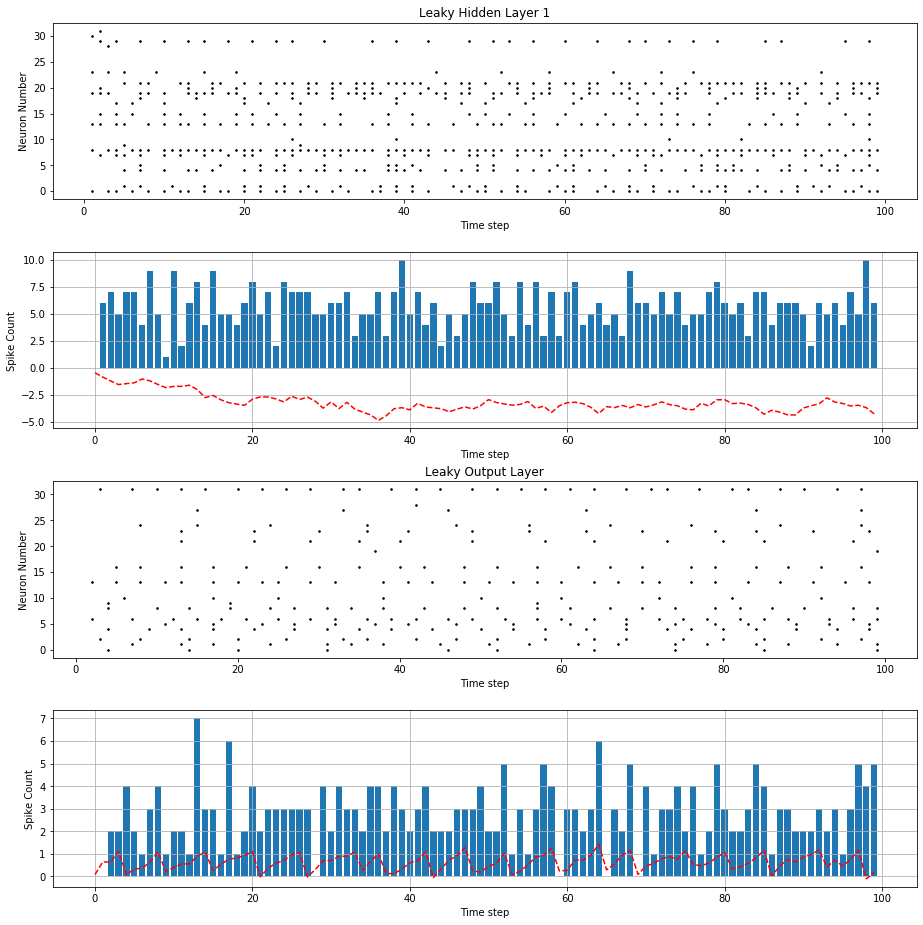

In [32]:
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

#  spike_data contains 128 samples, each of 100 time steps in duration
# print(spk1_rec.size())


#  Index into a single sample from a minibatch
spike_data1 = spk1_rec[:, 0, :]
# print(spike_data1.size())
spike_data2 = spk2_rec[:, 0, :]
# print(spike_data2.size())

mem_data1 = mem1_rec[:, 0, :]
print(spike_data1.size())
mem_data2 = mem2_rec[:, 0, :]
print(spike_data2.size())

fig = plt.figure(facecolor="w", figsize=(15, 15))
ax = fig.add_subplot(411)

#  s: size of scatter points; c: color of scatter points
splt.raster(spike_data1, ax, s=2.5, c="black")
plt.title("Leaky Hidden Layer 1")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")

# fig, ax = plt.subplots(facecolor='w', figsize=(15, 8))
ax2 = fig.add_subplot(412)
# noise = np.random.normal(0, 1, (1000, ))

# density = stats.gaussian_kde(Hist.detach().numpy())
# n, x, _ = plt.hist(Hist.detach().numpy(), bins=np.linspace(0, spike_data1.shape[0], 100)), 
#                    histtype=u'step', density=False)  
x = np.arange(num_steps)
# ax2.plot(x, density(x))
ax2.bar(x,SpikeTimeTotal.detach().numpy())
# ax2.plot(x, Hist.detach().numpy(),'r--')
ax2.plot(mem_data1[:,11].detach().numpy(),'r--')
plt.xlabel("Time step")
plt.ylabel("Spike Count")
plt.grid()
# plt.show()

ax3 = fig.add_subplot(413)
splt.raster(spike_data2, ax3, s=2.5, c="black")
plt.title("Leaky Output Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")

ax4 = fig.add_subplot(414)
# noise = np.random.normal(0, 1, (1000, ))

# density = stats.gaussian_kde(Hist.detach().numpy())
# n, x, _ = plt.hist(Hist.detach().numpy(), bins=np.linspace(0, spike_data1.shape[0], 100), 
#                    histtype=u'step', density=False)  
# ax2.plot(x, density(x))
ax4.bar(x,Hist2.detach().numpy())
# ax4.plot(x, Hist2.detach().numpy(),'g--')
ax4.plot(mem_data2[:,2].detach().numpy(),'r--')
plt.xlabel("Time step")
plt.ylabel("Spike Count")
plt.grid()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.3)
plt.show()

In [23]:
import pandas as pd
labels = [str(x+1) for x in np.arange(num_hidden)]
res = dict(zip(spk1_rec, labels))
df = pd.DataFrame(spike_data1.detach().numpy(),columns=labels)
SpikeTimeTotal = torch.sum(spike_data1,dim=1)
df.insert(num_hidden, "SpikeTimeTotal", SpikeTimeTotal.detach().numpy(), True)
df.tail()

,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,SpikeTimeTotal
95,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
96,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
97,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
98,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0
99,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [29]:
SpikeCount = torch.sum(spike_data1,dim=0)
SpikeSum = torch.tensor([torch.sum(SpikeCount)])
SpikeD = torch.cat((SpikeCount,SpikeSum),0)
# print(SpikeD)
Hist2 = torch.sum(spike_data2,dim=1)
df.loc[spike_data1.shape[0]] = SpikeD.detach().numpy() # Final row contains the total spikes of each neuron.
df.tail()  

tensor([ 52.,  29.,   0.,   0.,  49.,  20.,   0.,  36.,  83.,   2.,   5.,   0.,
          0.,  44.,   0.,  27.,   0.,  16.,  18.,  58.,  21.,  58.,   0.,  13.,
          0.,   0.,   0.,   0.,   1.,  29.,   1.,   1., 563.],
       grad_fn=<CatBackward>)


,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,SpikeTimeTotal
96,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
97,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
98,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0
99,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
100,52.0,29.0,0.0,0.0,49.0,20.0,0.0,36.0,83.0,2.0,...,13.0,0.0,0.0,0.0,0.0,1.0,29.0,1.0,1.0,563.0


In [25]:
idx_max = np.argmax(df[100:101])
print(idx_max)
print("Neuron with the most spikes was: ", df.iloc[100:101,:32].idxmax(axis=1), "with a value of: ",df.iloc[100:101,:32].max(axis=1))

32
Neuron with the most spikes was:  100    9
dtype: object with a value of:  100    83.0
dtype: float32


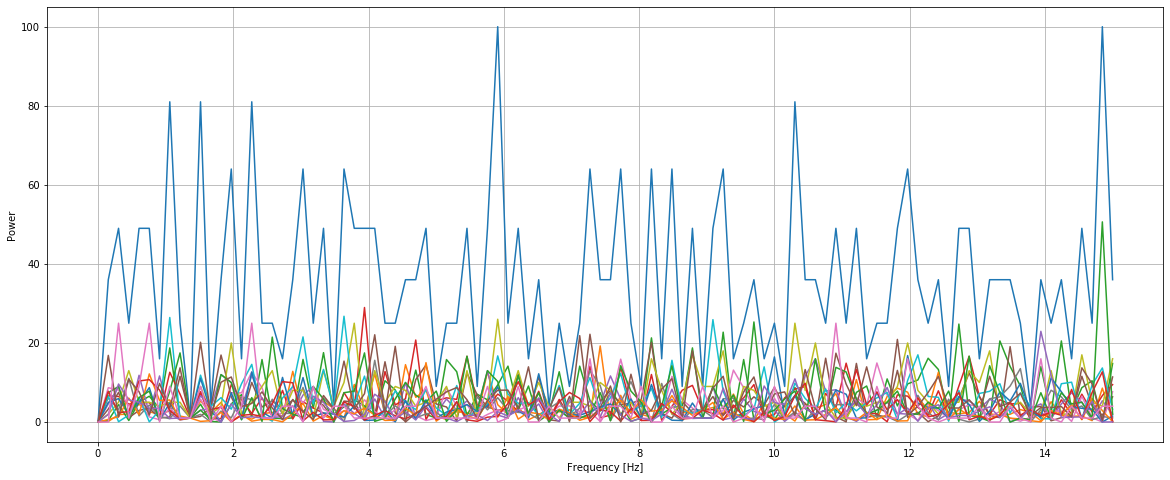

In [26]:
sampling_rate = 30.0

time = np.arange(0, spike_data1.shape[0], 1/sampling_rate)

data = spike_data1.detach().numpy()

fourier_transform = np.fft.rfft(data)

abs_fourier_transform = np.abs(fourier_transform)

power_spectrum = np.square(abs_fourier_transform)

frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))

fig = plt.figure(facecolor="w", figsize=(20, 8))
plt.plot(frequency, power_spectrum)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.grid()

# Dataset Plotting

In [24]:
import numpy as np
import csv
from sklearn.utils import Bunch

Train_XY_data = []
Target_XY_data = []
fd = open('SNNTrainingData.csv', 'r')
reader_xy = csv.reader(fd)
for row in reader_xy:
    Train_XY_data.append(row)

ft = open('SNNTargetData.csv', 'r')
reader_xy1 = csv.reader(ft)
for row in reader_xy1:
    Target_XY_data.append(row)

def load_SNN_dataset():

    return Bunch(data=Train_XY_data,target=Target_XY_data)

In [33]:
print(np.shape(Train_XY_data))

(20, 3)


(19, 3)
(19, 3)


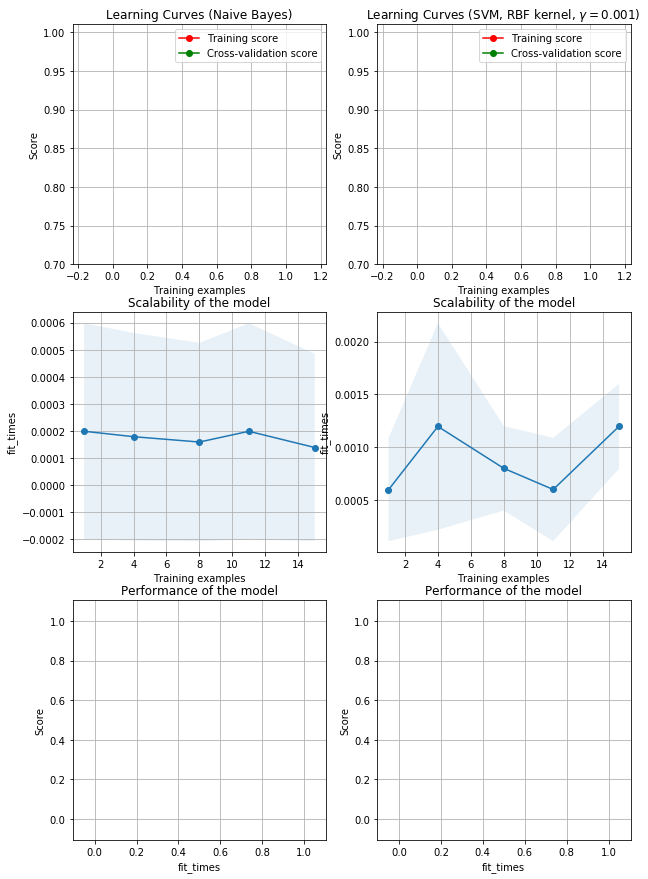

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# X, y = load_digits(return_X_y=True)
# import my_datasets
mfd = load_SNN_dataset()
# X = Train_XY_data 
X = mfd.data[1:]
print(np.shape(X))
# y = Target_XY_data 
y = mfd.target[:-1]
print(np.shape(y))

title = "Learning Curves (Naive Bayes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

In [26]:
!pip install plotly==5.9.0

     ---------------------------------------- 15.2/15.2 MB 6.7 MB/s eta 0:00:00


In [30]:
import plotly.graph_objects as go
import numpy as np

In [36]:
# Data for three-dimensional scattered points
z = 15 * np.random.random(100)
x = np.sin(z) + 0.1 * np.random.randn(100)
y = np.cos(z) + 0.1 * np.random.randn(100)
  
fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, color='green',
                                opacity=0.20, alphahull=3)])
  
fig.show()

In [36]:
import random 
random.randrange(1,9)

1

## Genetic Algo Test


In [24]:
# Import the os module
import os, sys

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

# Change the current working directory
# os.chdir(r"C:\Users\Pouya\Documents\SNN Controller\SRobotGym")
sys.path.append(r"C:\Users\Pouya\Documents\SNN Controller\SRobotGym\srobot")

# Print the current working directory
# sys.path.append(r"C:\Users\Pouya\Documents\SNN Controller\SRobotGym\srobot\envs")
print("Current working directory: {0}".format(os.getcwd()))


Current working directory: C:\Users\Pouya\Documents\SNN Controller\Soft-Robot-Repository\SRobotGym\srobot\envs
Current working directory: C:\Users\Pouya\Documents\SNN Controller\Soft-Robot-Repository\SRobotGym\srobot\envs


In [30]:
from TargetPathTrack import racetrack
from PlantSim import python_env
from RobotEnv import SRobotEnv

In [31]:
from gym import envs
# import srobot


In [32]:
import gym
num_turns = 1
env = gym.make('RobotEnv-v0', turns = num_turns)


UnregisteredEnv: No registered env with id: RobotEnv-v0